![text](header_workflow.png)

### MLP-based model compression 

#### Libraries

In [1]:
import os
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import seaborn as sn
import pandas as pd

## Tensorflow + Keras libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
from tensorflow_model_optimization.sparsity.keras import strip_pruning

## Quantization
from qkeras import *

## Datasets
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.datasets import cifar100
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2026-01-22 12:58:33.617960: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-22 12:58:33.982886: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-01-22 12:58:34.830772: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


#### Enable GPU 

In [2]:
# GPU
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices'

import tensorflow as tf
print("GPUs: ", len(tf.config.experimental.list_physical_devices('GPU')))

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)

    except RuntimeError as e:
        print(e)

GPUs:  1


2026-01-22 12:58:36.111692: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-22 12:58:36.305610: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-22 12:58:36.305778: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

#### Load dataset

In [3]:
# Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0          


#### Fashion MNIST: classes

| Label | Class |  
|-----------|-----------|
|0  | T-shirt/top	   |
|1	|Trouser    |
|2	|Pullover|
|3	|Dress|
|4	|Coat|
|5	|Sandal|
|6	|Shirt|
|7	|Sneaker|
|8	|Bag	|
|9	|Ankle boot|

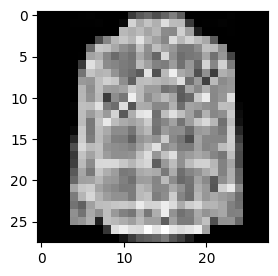

In [4]:
# Image index

N = 32

plt.figure(figsize=(3,3))
plt.imshow(x_train[N], cmap='gray')

In [5]:
# Labels
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

### Load model



In [6]:
model = load_model('fashionMNIST.h5')

2026-01-22 12:58:36.833315: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x16a20130 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2026-01-22 12:58:36.833344: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Host, Default Version
2026-01-22 12:58:36.833718: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-01-22 12:58:36.833901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
20

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 256)               200960    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 10)                330       
                                                                 
Total params: 219,818
Trainable params: 219,818
Non-trai

In [8]:
n_classes = 10
# One-hot encode labels
y_train = to_categorical(y_train, num_classes = n_classes)
y_test = to_categorical(y_test, num_classes = n_classes)

In [9]:
y_train

array([[0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

### Pruning

In [10]:
import math
epochs = 64
batch = 64
lr = 0.0001
op = Adam(lr)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
val_split = 0.2

final_sparsity = 0.2



N = x_train.shape[0]
N_train = int((1 - val_split) * N)
steps_per_epoch = math.ceil(N_train / batch)
end_step = steps_per_epoch * epochs

## PolynomialDecay: gradually increases the sparsity of a model over time using a polynomial function. 
# This helps in iterative pruning, where pruning is applied progressively rather than all at once, 
# improving accuracy retention.

pruning_params = {
                'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
                initial_sparsity=0, final_sparsity=final_sparsity, begin_step=0, end_step=end_step
                )
            }

In [11]:
modelP = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)

modelP.compile(optimizer=op, loss=loss, metrics=metrics)

### Model training

In [12]:
history = modelP.fit(
                x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                callbacks = [tfmot.sparsity.keras.UpdatePruningStep()],
                verbose=1
            )

Epoch 1/64


2026-01-22 12:58:39.363804: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2026-01-22 12:58:39.941091: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-01-22 12:58:39.986982: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8902
2026-01-22 12:58:40.086638: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


750/750 [==============================] - 5s 2ms/step - loss: 0.4586 - accuracy: 0.8392 - val_loss: 0.4241 - val_accuracy: 0.8512
Epoch 2/64
750/750 [==============================] - 2s 2ms/step - loss: 0.4179 - accuracy: 0.8525 - val_loss: 0.3984 - val_accuracy: 0.8546
Epoch 3/64
750/750 [==============================] - 2s 2ms/step - loss: 0.3931 - accuracy: 0.8599 - val_loss: 0.3792 - val_accuracy: 0.8645
Epoch 4/64
750/750 [==============================] - 2s 2ms/step - loss: 0.3736 - accuracy: 0.8669 - val_loss: 0.3687 - val_accuracy: 0.8677
Epoch 5/64
750/750 [==============================] - 1s 2ms/step - loss: 0.3554 - accuracy: 0.8728 - val_loss: 0.3546 - val_accuracy: 0.8761
Epoch 6/64
750/750 [==============================] - 1s 2ms/step - loss: 0.3449 - accuracy: 0.8764 - val_loss: 0.3502 - val_accuracy: 0.8763
Epoch 7/64
750/750 [==============================] - 1s 2ms/step - loss: 0.3301 - accuracy: 0.8824 - val_loss: 0.3423 - val_accuracy: 0.8781
Epoch 8/64
750/75

In [13]:
# Model evaluation
test_loss, test_acc = modelP.evaluate(x_test_norm, y_test)
print(f"\nTest accuracy: {test_acc:.4f}")

313/313 [==============================] - 0s 1ms/step - loss: 0.3448 - accuracy: 0.8911

Test accuracy: 0.8911


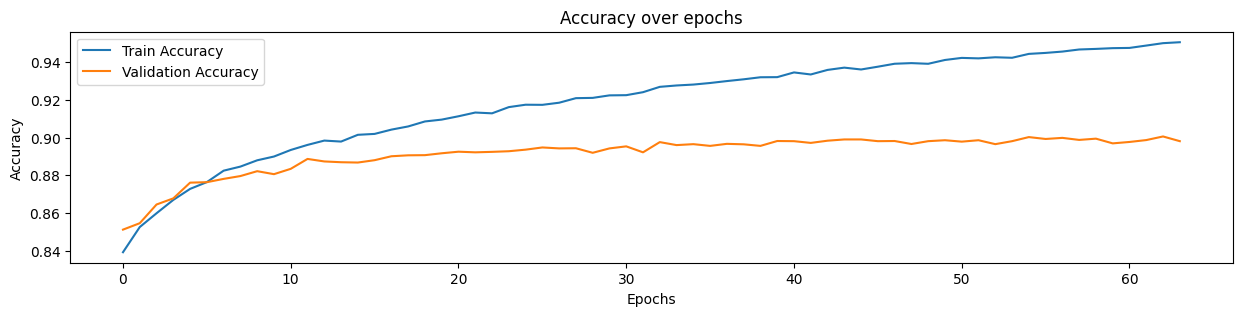

In [14]:
# Plot accuracy over epochs
plt.figure(figsize=(15,3))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over epochs')
plt.show()

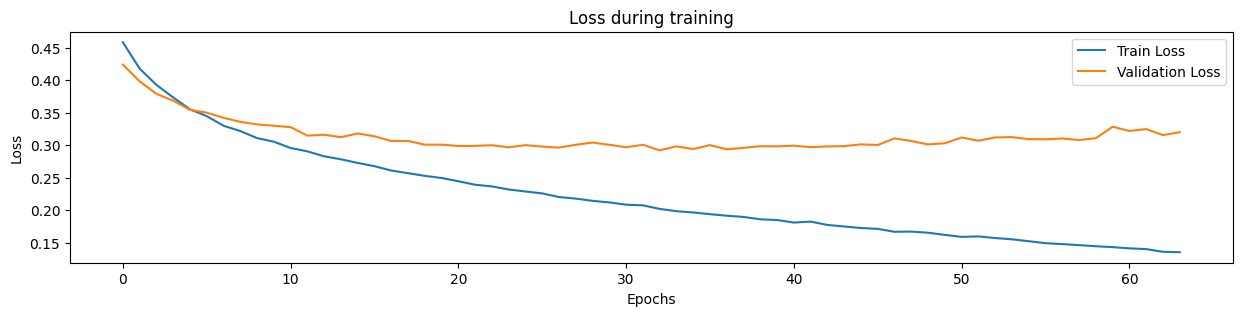

In [15]:
# Plot accuracy over loss
plt.figure(figsize=(15,3))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss during training')
plt.legend()
plt.show()

### Confusion Matrix

313/313 [==============================] - 0s 663us/step


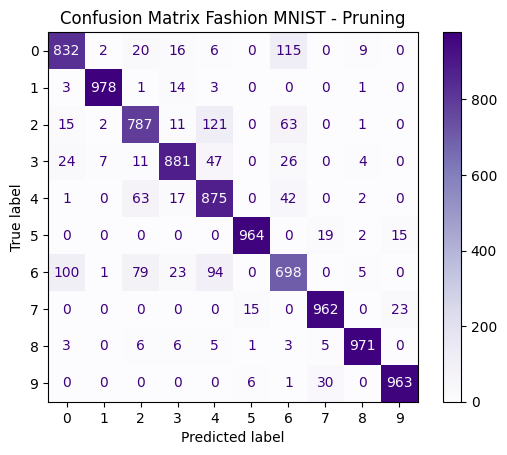

In [16]:
y_pred_probs = model.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix Fashion MNIST - Pruning')
plt.show()


### Quantization-aware training

QDense: A quantized version of Dense.

quantized_bits(N, M, alpha):

- N: Total bits used.

- M: Bits for the fractional part.

- alpha: Scaling factor.

QActivation: Applies quantized activations such as quantized_relu and quantized_softmax.

In [17]:

kernelQ = "quantized_bits(8,4,alpha=1)"
biasQ = "quantized_bits(8, 4,alpha=1)"
activationQ = 'quantized_bits(8, 4)'

modelQAT = Sequential(
            [   
                Flatten(input_shape=(28, 28)),
                QDense(250, name='fc1',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation= activationQ ,  name='relu1'),

                Dropout(0.1),

                QDense(100, name='fc2',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu2'), 
                Dropout(0.1),
                

                QDense(20, name='fc3',
                        kernel_quantizer=kernelQ, bias_quantizer=biasQ,
                        kernel_initializer='lecun_uniform'),
                QActivation(activation=activationQ, name='relu3'), 
                
                
                
                QDense(10, name='output',
                        kernel_quantizer= kernelQ, bias_quantizer= biasQ,
                        kernel_initializer='lecun_uniform'),
                Activation(activation='softmax', name='softmax')
               
            ],

            name="quantizedModel",
        )

/tools/anaconda3/envs/neuralEnv/lib/python3.10/site-packages/keras/initializers/initializers.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [18]:
modelQAT.summary()

Model: "quantizedModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 fc1 (QDense)                (None, 250)               196250    
                                                                 
 relu1 (QActivation)         (None, 250)               0         
                                                                 
 dropout (Dropout)           (None, 250)               0         
                                                                 
 fc2 (QDense)                (None, 100)               25100     
                                                                 
 relu2 (QActivation)         (None, 100)               0         
                                                                 
 dropout_1 (Dropout)         (None, 100)            

In [19]:
# Training (QAT)

epochs = 16
lr = 0.001
loss = 'categorical_crossentropy'
op = Adam(lr)
metrics = ['accuracy']
batch = 64
val_split = 0.2


modelQAT.compile(optimizer=op, loss=loss, metrics=metrics)
                
H = modelQAT.fit(x_train_norm, y_train,
                validation_split = val_split,
                epochs=epochs,
                batch_size = batch,
                verbose=1
                )


Epoch 1/16
750/750 [==============================] - 3s 2ms/step - loss: 1.2702 - accuracy: 0.7176 - val_loss: 0.6519 - val_accuracy: 0.7931
Epoch 2/16
750/750 [==============================] - 2s 2ms/step - loss: 0.7151 - accuracy: 0.7733 - val_loss: 0.5786 - val_accuracy: 0.8099
Epoch 3/16
750/750 [==============================] - 2s 2ms/step - loss: 0.6571 - accuracy: 0.7841 - val_loss: 0.6185 - val_accuracy: 0.8105
Epoch 4/16
750/750 [==============================] - 2s 2ms/step - loss: 0.6360 - accuracy: 0.7889 - val_loss: 0.6167 - val_accuracy: 0.7800
Epoch 5/16
750/750 [==============================] - 2s 2ms/step - loss: 0.6287 - accuracy: 0.7916 - val_loss: 0.5567 - val_accuracy: 0.8148
Epoch 6/16
750/750 [==============================] - 2s 2ms/step - loss: 0.6149 - accuracy: 0.7959 - val_loss: 0.5769 - val_accuracy: 0.8027
Epoch 7/16
750/750 [==============================] - 2s 2ms/step - loss: 0.5997 - accuracy: 0.7995 - val_loss: 0.5792 - val_accuracy: 0.8083
Epoch 

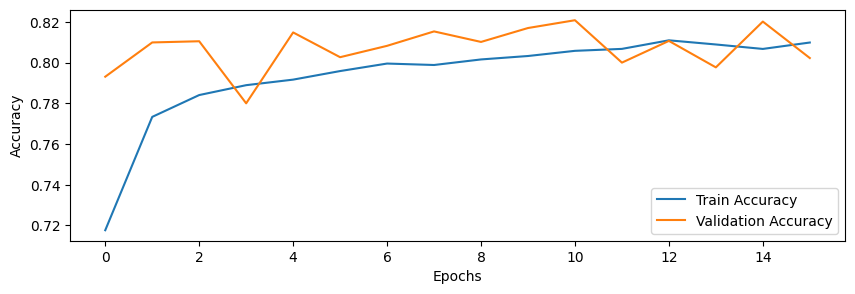

In [20]:
# Plot accuracy over epochs
plt.figure(figsize=(10,3))
plt.plot(H.history['accuracy'], label='Train Accuracy')
plt.plot(H.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

313/313 [==============================] - 1s 1ms/step


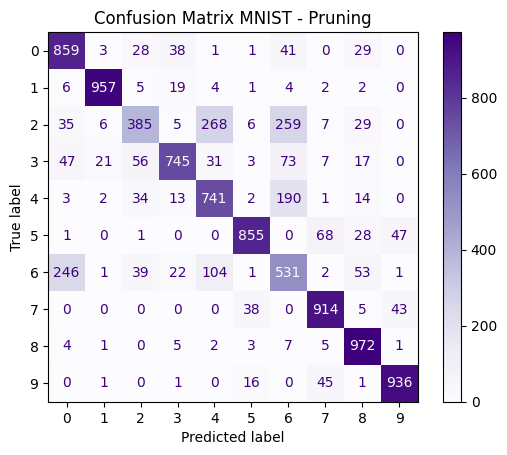

In [21]:
y_pred_probs = modelQAT.predict(x_test_norm)
y_pred = np.argmax(y_pred_probs, axis=1)

# Since y_test is one-hot encoded, you need to convert it back to class indices
y_true = np.argmax(y_test, axis=1)  # Convert one-hot encoded labels to class indices

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Purples")
plt.title('Confusion Matrix MNIST - Pruning')
plt.show()


---
Romina Soledad Molina, Ph.D. - MLab/STI ICTP, Trieste, Italy